# Implement AS algorithm ([Abreu and Sannikov 2014](https://econtheory.org/ojs/index.php/te/article/viewFile/20140313/10807/322))

In [1]:
using Games
using Polyhedra
using Plots
using LRSLib
import Games: _payoff_points

In [2]:
plib = getlibraryfor(2, Float64)

Polyhedra.SimplePolyhedraLibrary{Float64}()

## Replicate the simple example in the paper (p. 322)

The payoff bimatrix is

$$
\begin{bmatrix}
16,9 & 3,13 & 0,3 \\
21,1 & 10,4 & -1,0 \\
9,0 & 5,-4 & -5,-15 \\
\end{bmatrix}
$$

In [3]:
payoff_matrix1 = [16. 3. 0.
                  21. 10. -1.
                  9. 5. -5.]
payoff_matrix2 = [9. 1. 0.
                  13. 4. -4.
                  3. 0. -15.]

g = NormalFormGame(Player(payoff_matrix1), Player(payoff_matrix2))
rpd = RepeatedGame(g, 0.3)

Games.RepeatedGame{2,Float64}(3×3 NormalFormGame{2,Float64}, 0.3)

In [4]:
v = AS(rpd, u=[0, 0]);

converged in 20 iterations



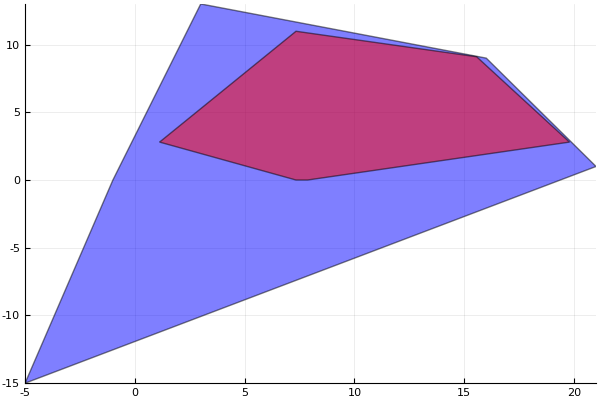

In [5]:
V = SimpleVRepresentation(v)
v_init = _payoff_points(g)
p_init = polyhedron(SimpleVRepresentation(v_init), plib)
plot(p_init, alpha=0.5, color="blue")
plot!(polyhedron(V, plib), alpha=0.5, color="red")

The speed can be significantly improved if we use LRSLib.LRSLibrary for transformation between VRepresenation and HRepresentation.

In [6]:
# the default library is SimplePolyhedraLibrary
@time v = AS(rpd, u=[0, 0]);
@time v = AS(rpd, u=[0, 0]);

converged in 20 iterations
  7.536476 seconds (20.03 M allocations: 964.475 MiB, 5.43% gc time)
converged in 20 iterations
  5.389383 seconds (18.91 M allocations: 900.187 MiB, 6.81% gc time)


In [7]:
# try to use LRSLib.LRSLibrary
@time v = AS(rpd, u=[0, 0], plib=LRSLib.LRSLibrary());
@time v = AS(rpd, u=[0, 0], plib=LRSLib.LRSLibrary());

converged in 20 iterations
  4.146301 seconds (3.28 M allocations: 151.726 MiB, 3.28% gc time)
converged in 20 iterations
  0.644643 seconds (1.93 M allocations: 76.929 MiB, 10.41% gc time)


## Replicate the Cournot duopoly game in the paper (p. 326)

In [8]:
# generate Cournot game
# borrow code from quantecon notebook written by Daisuke Oyama
immutable Cournot{N} end

function (::Type{Cournot{N}}){N,T<:Real}(a::Real, c::Real, q_grid::Vector{T})
    nums_actions = tuple([length(q_grid) for i in 1:N]...)::NTuple{N,Int}
    S = promote_type(typeof(a), typeof(c), T)
    payoff_array= Array{T}(nums_actions)
    for I in CartesianRange(nums_actions)
        Q = zero(S)
        for i in 1:N
            Q += q_grid[I[i]]::T
        end
        payoff_array[I] = (a - c - Q) * q_grid[I[1]]
    end
    players = tuple([Player(payoff_array) for i in 1:N]...)::NTuple{N,Player{N,T}}
    return NormalFormGame(players)
end

cournot{T<:Real}(a::Real, c::Real, N::Integer, q_grid::Vector{T}) =
    Cournot{N}(a, c, q_grid)

cournot (generic function with 1 method)

In [9]:
a, c = 6, 0.6
N = 2
q_grid = collect(linspace(0, 6, 15))  # [0, 5, 10, ..., 60]
g_Cou = cournot(a, c, N, q_grid)
rpd_Cou = RepeatedGame(g_Cou, 0.8)

Games.RepeatedGame{2,Float64}(15×15 NormalFormGame{2,Float64}, 0.8)

In [10]:
@time v = AS(rpd_Cou, plib=LRSLib.LRSLibrary(), tol=1e-4, u=[0, 0]);

converged in 23 iterations
 57.594747 seconds (214.87 M allocations: 7.914 GiB, 17.25% gc time)



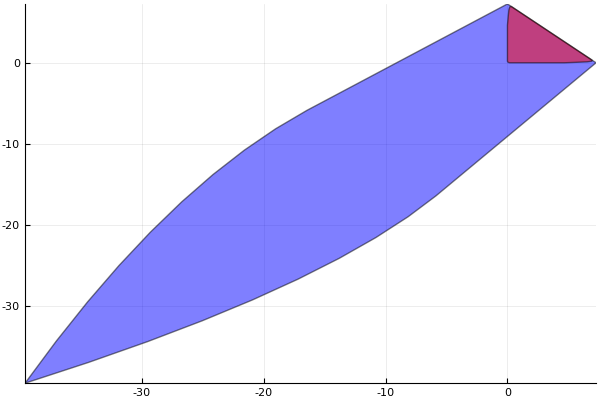

In [11]:
v_init = _payoff_points(g_Cou)
p_init = polyhedron(SimpleVRepresentation(v_init), LRSLib.LRSLibrary())
plot(p_init, alpha=0.5, color="blue")
plot!(polyhedron(SimpleVRepresentation(v), LRSLib.LRSLibrary()), alpha=0.5, color="red")

However, the speed is way slower comparing to the Java implementation in the paper (0.34s).

## Compare JYC and AS

We use the same Prisoner Delimma example in the [Repeated Game notebook](https://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/recursive_repeated_games.ipynb#One-Shot-Prisoner's-Dilemma), and compare the speed of JYC and AS.

In [12]:
pd_payoff = [9. 1.
             10. 3.]
pd = NormalFormGame(pd_payoff)

rpd1 = RepeatedGame(pd, 0.9)
rpd2 = RepeatedGame(pd, 0.2475)

Games.RepeatedGame{2,Float64}(2×2 NormalFormGame{2,Float64}, 0.2475)

First we show the result of JYC algorithm.

In [13]:
@time v = outerapproximation(rpd1; nH=128, maxiter=750, tol=1e-8);
@time v = outerapproximation(rpd1; nH=128, maxiter=750, tol=1e-8);
@time v = outerapproximation(rpd2; nH=128, maxiter=750, tol=1e-8);
@time v = outerapproximation(rpd2; nH=128, maxiter=750, tol=1e-8);

 42.568157 seconds (72.51 M allocations: 4.334 GiB, 3.73% gc time)
 39.090483 seconds (71.13 M allocations: 4.262 GiB, 3.94% gc time)
 14.293543 seconds (63.72 M allocations: 2.948 GiB, 8.24% gc time)
 14.167239 seconds (63.72 M allocations: 2.948 GiB, 8.30% gc time)


Following is the result of AS algorithm.

In [14]:
@time v1 = AS(rpd1, max_iter=500, plib=plib)
@time v2 = AS(rpd2, max_iter=500, plib=plib)

converged in 111 iterations
 12.143928 seconds (42.75 M allocations: 1.978 GiB, 7.26% gc time)
converged in 26 iterations
  3.315870 seconds (11.48 M allocations: 543.722 MiB, 7.10% gc time)


7×2 Array{Float64,2}:
 9.0      9.0    
 9.06386  8.2675 
 8.2675   9.06386
 9.52311  3.0    
 3.0      9.52311
 3.0      3.0    
 3.0      3.0    


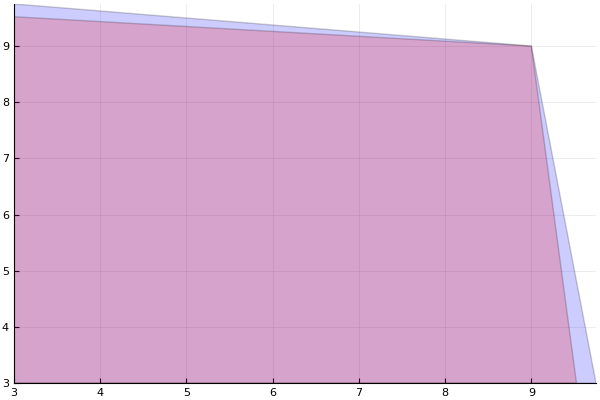

In [15]:
plot(polyhedron(SimpleVRepresentation(v1), plib), alpha=0.2, color="blue")
plot!(polyhedron(SimpleVRepresentation(v2), plib), alpha=0.2, color="red")

If we use `SimplePolyhedraLibrary`, something weird will happen if we set very small `tol`.

converged in 172 iterations
 16.992605 seconds (60.35 M allocations: 2.793 GiB, 7.35% gc time)
 35.349570 seconds (119.10 M allocations: 5.522 GiB, 6.80% gc time)



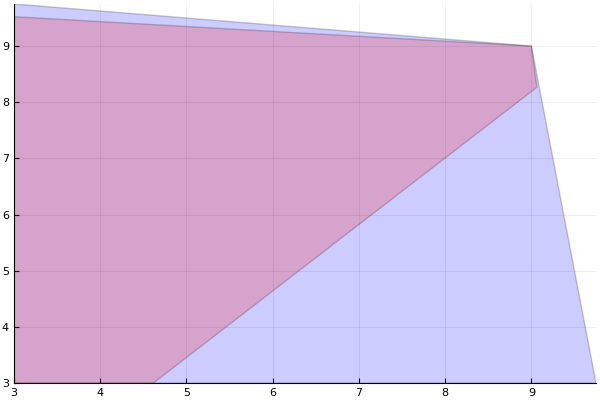

In [16]:
@time v1 = AS(rpd1, max_iter=500, plib=plib, tol=1e-8)
@time v2 = AS(rpd2, max_iter=500, plib=plib, tol=1e-8)
plot(polyhedron(SimpleVRepresentation(v1), plib), alpha=0.2, color="blue")
plot!(polyhedron(SimpleVRepresentation(v2), plib), alpha=0.2, color="red")

Again, using LRSLib.LRSLibrary gives significant improvement in speed.

In [17]:
@time v1 = AS(rpd1, max_iter=500, plib=LRSLib.LRSLibrary(), tol=1e-8)
@time v1 = AS(rpd1, max_iter=500, plib=LRSLib.LRSLibrary(), tol=1e-8)
@time v2 = AS(rpd2, max_iter=500, plib=LRSLib.LRSLibrary(), tol=1e-8)
@time v2 = AS(rpd2, max_iter=500, plib=LRSLib.LRSLibrary(), tol=1e-8)

converged in 195 iterations
  4.213204 seconds (12.95 M allocations: 528.720 MiB, 15.93% gc time)
converged in 195 iterations
  4.186218 seconds (12.91 M allocations: 526.458 MiB, 17.02% gc time)
converged in 79 iterations
  1.647155 seconds (4.88 M allocations: 198.833 MiB, 17.77% gc time)
converged in 79 iterations
  1.593601 seconds (4.88 M allocations: 198.836 MiB, 15.93% gc time)


5×2 Array{Float64,2}:
 9.0     9.0   
 9.5231  3.0   
 3.0     9.5231
 3.0     3.0   
 3.0     3.0   


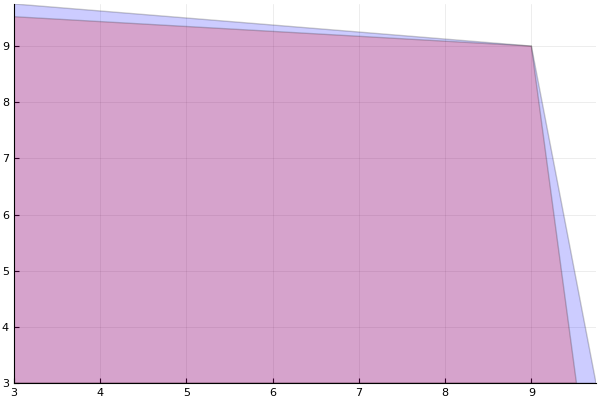

In [18]:
plot(polyhedron(SimpleVRepresentation(v1), plib), alpha=0.2, color="blue")
plot!(polyhedron(SimpleVRepresentation(v2), plib), alpha=0.2, color="red")